### Attempt 2

VGG16 with residuals, and attention for numerical data. 

CNN's linear head is kneecapped to dimension reduction, 2 components feed into one linear head. 

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from datetime import datetime
import time
import os.path
from sklearn.metrics import r2_score

In [2]:
# colab stuff

# ! pip install -q kaggle
# from google.colab import files
# files.upload()

In [3]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c cs-480-2024-spring
# ! mkdir data
# ! unzip -q cs-480-2024-spring.zip -d data

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

if device == torch.device("cuda:0"):
  print('On GPU')
else:
  print('On CPU')

On CPU


In [5]:
class Hyperparameter:
    num_predictions: int    = 6

    # hyperparams
    batch_size: int         = 64
    num_epochs: int         = 5

    vgg_output_size: int    = 128
    fc_output_size: int     = 128

    # bookkeeping
    batch_report_gap: int   = 100
    sav_model_epoch: bool   = True

    # optimizer
    learning_rate: float    = 0.001


hp = Hyperparameter()

## Data Manips

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    ])
# TODO: transform some gaussian noise

In [7]:
class CustomDataset(Dataset):
    def __init__(self, img_id, data, target, img_dir, transform=None):
        self.img_id = img_id
        self.data_frame = data
        self.target = target
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.img_id[idx]}.jpeg")
        image = np.array(plt.imread(img_name), dtype=np.float32)
        if self.transform:
            image = self.transform(image)

        training_data = torch.tensor(self.data_frame[idx])
        target_data = torch.tensor(self.target[idx])

        return image, training_data, target_data


In [8]:
train_data = pd.read_csv('data\\train.csv')
IMG_ID = train_data['id']
X = np.array(train_data, dtype=np.float32)[:, 1:-6]
Y = np.array(train_data, dtype=np.float32)[:, -6:]

# X = X[:1000]
# Y = Y[:1000]

split_index = int(np.round(0.85 * len(X)))

train_img_id = IMG_ID[:split_index]
train_x = X[:split_index]
train_y = Y[:split_index]
train_dataset = CustomDataset(train_img_id, train_x, train_y, img_dir='data\\train_images', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=hp.batch_size, shuffle=True)

test_img_id = IMG_ID[split_index:].reset_index(drop=True)
test_x = X[split_index:]
test_y = Y[split_index:]
test_dataset = CustomDataset(test_img_id, test_x, test_y, img_dir='data\\train_images', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=hp.batch_size, shuffle=False)

len(train_x), len(test_x), len(train_dataloader), len(test_dataloader)

(850, 150, 14, 3)

In [ ]:
# kaggle test data (no target given)
evaluation_data = pd.read_csv('data\\test.csv')
eval_img_id = evaluation_data['id']
eval_x = np.array(evaluation_data, dtype=np.float32)
eval_y = np.zeros((6391,6), dtype=np.float32) # empty

eval_dataset = CustomDataset(eval_img_id, eval_x, eval_y, img_dir='data\\test_images', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=hp.batch_size, shuffle=False)

# MODEL

### VGG16 with Residuals

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # handle residual identity passthrough if in/out dimensions mismatch
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv_block(x) + identity
        out = self.relu(out)
        return out

In [11]:
class ResidualVGG16(nn.Module):
    def __init__(self):
        super(ResidualVGG16, self).__init__()
        self.cnn = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(128, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(256, 512),
            ResidualBlock(512, 512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_head = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.linear_head(x)
        return x


### Attention structure for numerical data

In [12]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True):
        super(Attention, self).__init__()
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.bias = bias
        self.weight = nn.Parameter(torch.Tensor(feature_dim, 1))
        if bias:
            self.b = nn.Parameter(torch.Tensor(step_dim))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        eij = torch.matmul(x, self.weight).squeeze(2)
        if self.bias:
            eij = eij + self.b
        a = torch.tanh(eij)
        a = torch.exp(a)
        a = a / torch.sum(a, 1, keepdim=True)
        weighted_input = x * a.unsqueeze(-1)
        return torch.sum(weighted_input, 1)

In [13]:
class MultiAttention(nn.Module):
    def __init__(self, feature_dim):
        super(MultiAttention, self).__init__()
        self.attention1 = Attention(feature_dim, step_dim=1)
        self.attention2 = Attention(feature_dim, step_dim=1)
        self.attention3 = Attention(feature_dim, step_dim=1)

    def forward(self, x):
        x1 = self.attention1(x.unsqueeze(1))
        x2 = self.attention2(x1.unsqueeze(1))
        x3 = self.attention3(x2.unsqueeze(1))
        return x3

In [14]:
class BigBoy(nn.Module):
    def __init__(self):
        super(BigBoy, self).__init__()

        self.cnn = ResidualVGG16()
        self.cnn_block = nn.Sequential(
            self.cnn,
            nn.Linear(1024, 128), # output of VGG16 is 1024, into 128
            nn.ReLU(inplace=True)
        )
        
        self.data_multiheadattention = MultiAttention(feature_dim=163)
        self.data_block = nn.Sequential(
            self.data_multiheadattention,
            nn.Linear(163, 128), 
            nn.ReLU(inplace=True)
        )

        self.combiner_multiheadattn_block = nn.MultiheadAttention(embed_dim=256, num_heads=8, batch_first=True)

        
        self.linear_head = nn.Sequential(
            nn.Linear(256, 128), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 6)
        )

    def forward(self, image, data):
        processed_image = self.cnn_block(image)
        processed_data = self.data_block(data) 

        combined_features = torch.cat((processed_image, processed_data), dim=1)
        
        attn_output, _ = self.combiner_multiheadattn_block(combined_features, combined_features, combined_features)
        
        out = self.linear_head(attn_output)
        return out

In [15]:
# model = BigBoy()

# for image, data, target in train_dataloader:
#     print(model(image, data).shape)
#     break

# Model training and stuff

In [16]:
# bookkeeping block

class bookkeeper():
    def __init__(self, key_lst, total_batches):

        # graphs
        self.lists = {}
        for key in key_lst:
            self.lists[key] = []
        
        self.batch_loss_list = []

        # timer 
        self.start_time = time.time()
        self.total_batches = total_batches
        self.local_batches_completed = 0
        self.batches_completed = 0
        self.epochs_completed = 0

    def append(self, key, val):
        self.lists[key].append(val)

    def plot(self):
        for k in self.lists:
            if k != 'epoch':
                plt.title(k)
                plt.plot(self.lists['epoch'][1:], self.lists[k][1:]) #ignore 1st entry, too big
                plt.show()

        # plot batch loss moving average of window size 5:
        data_series = pd.Series(self.batch_loss_list)
        moving_average = data_series.rolling(window=10, center=False).mean()
        plt.plot(moving_average, label='batch loss (mv avg 10)')
        plt.show()


    def reset_timer(self):
        self.start_time = time.time()
    
    def elapsed_time(self):
        elapsed = time.time() - self.start_time
        hours, rem = divmod(elapsed, 3600)
        minutes, seconds = divmod(rem, 60)
        return 'ELAPSED: ' + f"{int(hours):02}h {int(minutes):02}m {int(seconds):02}s"

    def eta(self):
        progress = (self.batches_completed+1) / self.total_batches
        elapsed = time.time() - self.start_time
        work_rate = elapsed / progress
        remaining_work = self.total_batches - self.batches_completed
        eta = time.time() + (remaining_work / work_rate)
        formatted_eta = datetime.fromtimestamp(eta).strftime("%H:%M:%S")
        return 'ETA: ' + formatted_eta
    
    
    def tick_batch(self, batch_loss):
        self.local_batches_completed += 1
        self.batches_completed += 1

        self.batch_loss_list.append(batch_loss)

        if self.batches_completed % hp.batch_report_gap == 0:
            print('Epoch', self.epochs_completed,
                  'Batch', f"{self.local_batches_completed:03}", 
                  batch_loss, '|',
                  self.elapsed_time(), '|',
                  self.eta())

    def tick_epoch(self, train_loss, test_loss, r2):
        self.epochs_completed += 1
        self.local_batches_completed = 0

        print('### Epoch', self.epochs_completed, '|',
              self.elapsed_time(), '|',
              self.eta())
        print('train_loss', train_loss, 'test_loss', test_loss, 'r2',r2)
        print()


# Running the model

In [17]:
model = BigBoy()
model_to_load = None # 'model_savs\\model.sav'
if model_to_load:
    if os.path.isfile(model_to_load):
        model.load_state_dict(torch.load('model_to_load'))
        model.eval()
        print('loaded', model_to_load)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=hp.learning_rate)
lambda_lr = lambda step: 0.9 ** step
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr)
criterion = nn.MSELoss()
bk = bookkeeper(key_lst = ['epoch', 'train_loss', 'test_loss', 'test_R2'], 
                total_batches = train_x.shape[0] * hp.num_epochs)

In [18]:
bk.reset_timer()

for e in range(hp.num_epochs):
    model.train()

    running_loss = 0.0

    for images, data, target in train_dataloader:
        optimizer.zero_grad()

        images = images.to(device)
        data = data.to(device)
        target = target.to(device)

        prediction = model(images, data)
        loss = criterion(prediction, target)

        loss.backward()
        optimizer.step()
        bk.tick_batch(loss.item())

        running_loss += loss.item()
    
    train_loss = running_loss / train_x.shape[0]

    scheduler.step()

    ###################################################

    model.eval()

    test_loss = 0.0
    acc_predictions = [] # hold onto predictions and targets for R2
    acc_targets = []

    with torch.no_grad():
        for images, data, target in test_dataloader:

            images = images.to(device)
            data = data.to(device)
            target = target.to(device)

            prediction = model(images, data)
            test_loss += criterion(prediction, target)

            acc_predictions.append(prediction)
            acc_targets.append(target)

    test_loss = test_loss.item() / len(test_dataloader)
    r2 = r2_score(np.concatenate(acc_targets), np.concatenate(acc_predictions))

    ###################################################
    # bookkeeping
    bk.append('epoch', e)
    bk.append('train_loss', train_loss)
    bk.append('test_loss', test_loss)
    bk.append('test_R2', r2)  
    bk.tick_epoch(train_loss, test_loss, r2)

    # save model every epoch
    if hp.sav_model_epoch:
        torch.save(model.state_dict(), f"data\\model_epoch{e+1}.sav")



### Epoch 1 | ELAPSED: 00h 01m 48s | ETA: 23:12:35
train_loss 320388123.7082353 test_loss 31429505318912.0 r2 -11800385971023.111

### Epoch 2 | ELAPSED: 00h 03m 27s | ETA: 23:14:14
train_loss 111250121.48705882 test_loss 7933891619498.667 r2 -7470186010.260177

### Epoch 3 | ELAPSED: 00h 05m 07s | ETA: 23:15:54
train_loss 101317422.68235295 test_loss 13737598976.0 r2 -239541420.65062836

Epoch 3 Batch 008 8420788736.0 | ELAPSED: 00h 06m 03s | ETA: 23:16:50
### Epoch 4 | ELAPSED: 00h 06m 46s | ETA: 23:17:33
train_loss 117792120.47058824 test_loss 6809673728.0 r2 -92947087.77736253

### Epoch 5 | ELAPSED: 00h 08m 24s | ETA: 23:19:11
train_loss 95474940.9882353 test_loss 41500175018.666664 r2 -245894747.6772171



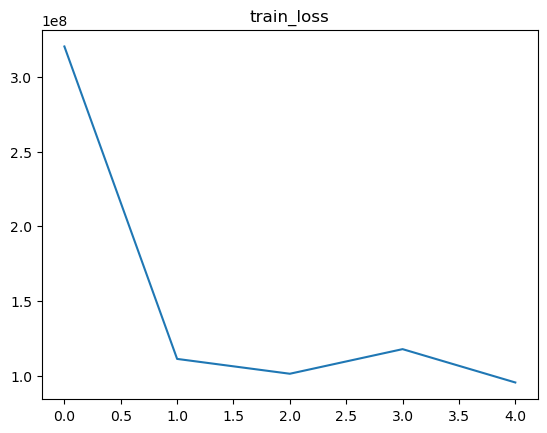

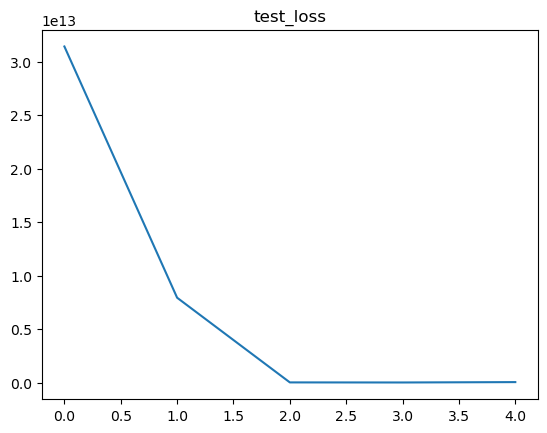

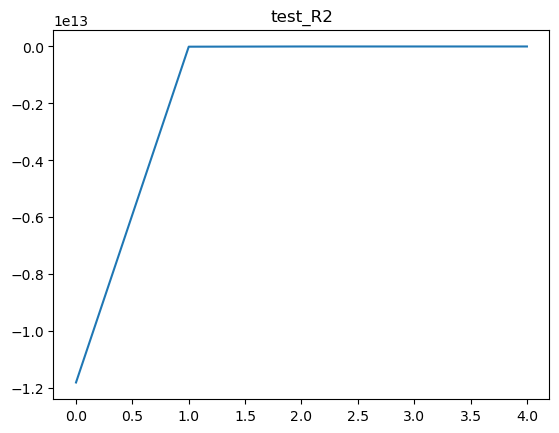

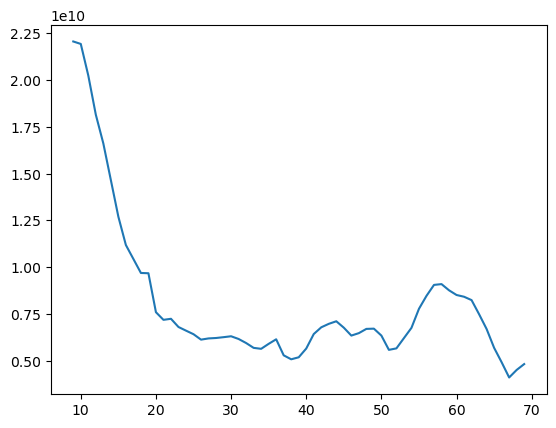

In [19]:
bk.plot()